In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import sunpy.map

from pathlib import Path
import numpy as np
import datetime

import pdb
import importlib
import pickle, json
import locale

locale.setlocale(locale.LC_ALL, "C");

In [47]:
import query_sunpy
importlib.reload(query_sunpy);

In [45]:
def cutout2box (_map, center_x, center_y , dx_km, shape):
    hmi_wcs = _map.wcs

    center_crd = crd = SkyCoord(center_x,center_y, unit=u.arcsec, frame=_map.coordinate_frame)\
                        .transform_to("heliographic_carrington")
    lon = center_crd.lon
    lat = center_crd.lat
    rad = center_crd.radius
    origin = SkyCoord(lon, lat, rad,
                      frame="heliographic_carrington",
                      observer="self",
                      obstime=_map.date)

    scale = np.arcsin(dx_km/origin.radius).to(u.deg)/u.pix
    scale = u.Quantity((scale, scale))
    box_header = sunpy.map.make_fitswcs_header(shape, origin,
                                               projection_code='CEA', scale=scale)

    outmap = _map.reproject_to(box_header, algorithm="adaptive", roundtrip_coords=False)

    return outmap

In [ ]:
def hmi_b2ptr(index, bvec):
    sz = bvec.shape
    nx, ny, nz = sz
    # nz should equal 3

    field = bvec[:,:,0]
    gamma = np.deg2rad(bvec[:,:,1])
    psi   = np.deg2rad(bvec[:,:,2])
    
    b_xi  = -field * np.sin(gamma) * np.sin(psi)
    b_eta  = field * np.sin(gamma) * np.cos(psi)
    b_zeta = field * np.cos(gamma)

    # WCS conversion
    #wcs = fitshead2wcs(index)
    #coord = wcs_get_coord(wcs)
    # Get Stonyhurst lon/lat
    #wcs_convert_from_coord, wcs, coord, 'HG', phi, lambda
    
    b = np.deg2rad(index["crlt_obs"])
    p = np.deg2rad(-index["crota2"])
    
    phi, lambda_ = np.deg2rad(phi), np.deg2rad(lambda_)

    sinb, cosb = np.sin(b), np.cos(b)
    sinp, cosp = np.sin(p), np.cos(p)
    sinphi, cosphi = np.sin(phi), np.cos(phi)          # nx*ny
    sinlam, coslam = np.sin(lambda_), np.cos(lambda_)  # nx*ny

    k11 = coslam * (sinb * sinp * cosphi + cosp * sinphi) - sinlam * cosb * sinp
    k12 = - coslam * (sinb * cosp * cosphi - sinp * sinphi) + sinlam * cosb * cosp
    k13 = coslam * cosb * cosphi + sinlam * sinb
    k21 = sinlam * (sinb * sinp * cosphi + cosp * sinphi) + coslam * cosb * sinp
    k22 = - sinlam * (sinb * cosp * cosphi - sinp * sinphi) - coslam * cosb * cosp
    k23 = sinlam * cosb * cosphi - coslam * sinb
    k31 = - sinb * sinp * sinphi + cosp * cosphi
    k32 = sinb * cosp * sinphi + sinp * cosphi
    k33 = - cosb * sinphi

    bptr = np.zeros((nx, ny, 3))

    bptr[:,:,0] = k31 * b_xi + k32 * b_eta + k33 * b_zeta
    bptr[:,:,1] = k21 * b_xi + k22 * b_eta + k23 * b_zeta
    bptr[:,:,2] = k11 * b_xi + k12 * b_eta + k13 * b_zeta

    return bptr

In [49]:
dl_path = "input_data/"

In [50]:
start_date = datetime.datetime.fromisoformat("2014-02-02T02:22:00.0")
end_date   = datetime.datetime.fromisoformat("2014-02-02T02:22:15.0")

In [10]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, print_only=True)

In [11]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, print_only=False)

In [51]:
#def gx_box_from_dir(cache_dir, model_dir, x, y, dx, dy, dz, res_km, top=0, cea=1, sfq=1, carrington=0):

x=-230
y=-110
dx=512
dy=256
dz=128

res_km=360.49

input_path = Path(os.path.expanduser(dl_path)).resolve()

if not input_path.exists():
    print("no input data")

field_path = list(input_path.glob("*.field.fits"))[0]
incli_path = list(input_path.glob("*.inclination.fits"))[0]
azimu_path = list(input_path.glob("*.azimuth.fits"))[0]
disam_path = list(input_path.glob("*.disambig.fits"))[0]
conti_path = list(input_path.glob("*.continuum.fits"))[0]
losma_path = list(input_path.glob("*.magnetogram.fits"))[0]
size_pix = f"[{dx}, {dy}, {dz}]"
centre = f"[{x}, {y}]"
wcs_rsun=6.96e8

In [53]:
#reading data from fits
map_field       = sunpy.map.Map(field_path)
map_inclination = sunpy.map.Map(incli_path)
map_azimuth     = sunpy.map.Map(azimu_path)
map_disambig    = sunpy.map.Map(disam_path)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
2024-04-02 08:45:59 - sunpy - WARNING: SunpyMetadataWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
2024-04-02 08:45:59 - sunpy - WARNING: SunpyMetadataWarning: Could not parse unit string "degree" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata

In [62]:
#calculating Bz, Bx, By
incl = np.deg2rad(map_inclination.data)
bz = map_field.data * np.cos(incl)
bt = map_field.data * np.sin(incl)
az  = map_azimuth.data
dis = map_disambig.data
az = np.deg2rad(az + dis*180.)  # applying disambiguation
by = -bt * np.cos(az)
bx =  bt * np.sin(az)

In [63]:
#TODO: calulating Br, Btheta and Bphi

#Forming maps for Br Btheta By
header = map_field.fits_header
map_bz = sunpy.map.Map(bz, header)
map_bx = sunpy.map.Map(bx, header)
map_by = sunpy.map.Map(by, header)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
2024-04-02 10:30:41 - sunpy - WARNING: SunpyMetadataWarning: Could not parse unit string "Mx/cm^2" as a valid FITS unit.
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


In [64]:
box_bx = cutout2box(map_bx, x, y, res_km * u.km, [dy, dx])
box_by = cutout2box(map_by, x, y, res_km * u.km, [dy, dx])
box_bz = cutout2box(map_bz, x, y, res_km * u.km, [dy, dx])

In [92]:
earth_observer = SkyCoord(0*u.deg, 0*u.deg, 0*u.km, frame=frames.GeocentricEarthEquatorial, observer="earth", obstime=box_bx.date)

In [138]:
ny, nx = box_bx.data.shape

xp, yp = np.mgrid[0:nx:1, 0:ny:1]
ypxp = np.stack([yp, xp]).T

In [166]:
world_coordinates = box_bx.pixel_to_world(xp*u.pixel, yp*u.pixel)
e_r = world_coordinates.transform_to(frames.Heliocentric).cartesian

In [171]:
er_abs = np.sqrt(e_r.x**2 + e_r.y**2 + e_r.z**2)
e_r_1 = e_r / er_abs

In [184]:
B_r = (box_bx.data.T * e_r_1.x +\
      box_by.data.T * e_r_1.y +\
      box_bz.data.T * e_r_1.z).T

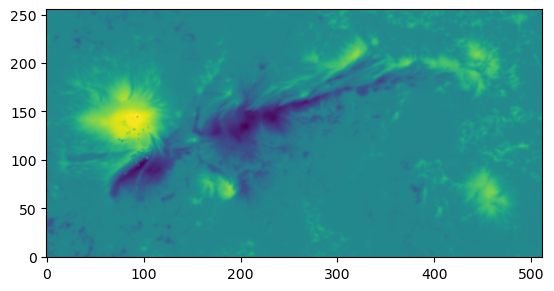

In [185]:
plt.imshow(B_r, origin="lower")

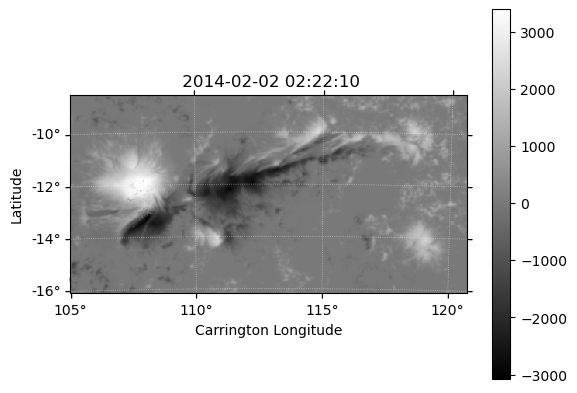

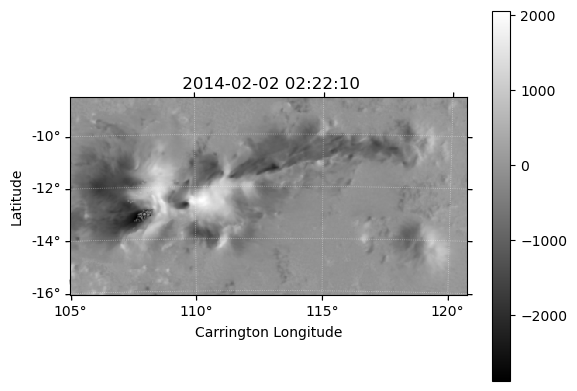

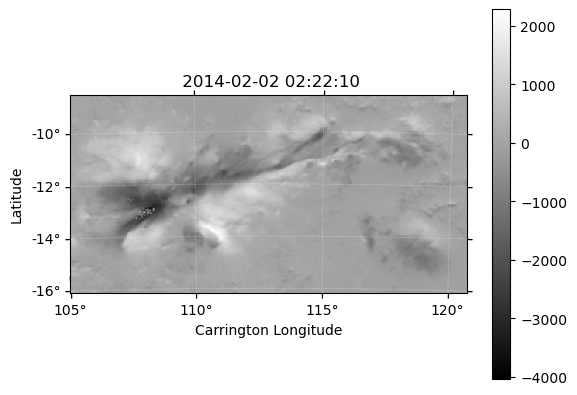

In [65]:
box_bz.peek()
box_bx.peek()
box_by.peek()

In [32]:
#field_fits = fits.open(field_path, unit_parse_warning="silent")
#field_fits.verify("fix")
#field_fits[1].header['cunit1'] = 'arcsec' 
#field_fits[1].header['cunit2'] = 'arcsec' 

In [36]:
#res_step = (sp_map.rsun_obs / sp_map.rsun_meters.to("km") * res_km).value

In [37]:
#res_step

0.504333497436348